## Current Python Version

Ensure the python version running in the jupyter kernel is the same as expected

In [1]:
# from platform import python_version

# print(python_version())


List installed packages, should match the ones in the pipfile (and their dependencies)

In [2]:
# pip list

## Internal Module Imports
Code required to enable project's internally defined modulos into the jupyter notebook environment

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
# from electricity import ElectricalSystem, Load, Generator
from dto import (
    COST_PRESETS, 
    ElectricalSystemSpecs, 
    EpsilonSpecs,
    GeneratorSpecs, 
    LoadSpecs, 
    NodeStatePower, 
    SystemHistory, 
    )
    
from learning import ModelTrainer, ModelTester, LearningParams

/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 

Determine the experiment params

In [5]:
from dto import EpsilonSpecs, ElectricalConstants
import math

LearningParams(
    gamma=0.9,   # Gamma (Discount)
    tau=0.001, # Tau
    epsilonSpecs = EpsilonSpecs( # Epsilon explore/exploit control
        thresholdProgress = 0.6, # % of steps where decay change should happen
        thresholdValue = 0.5, # Value at which decay change would happen
        finalValue = 0.0001, # Value at the end of the experiment
    ),
    numEpisodes=500, # Number of learning episodes to run
    maxSteps=100,   # Number of steps per learning episode
    bufferSize=100, # Experience Buffer Size
    traceLength=20,     # Number of steps each sampled episode should contain
    batchSize=4,     # Number of episodes sampled from experience buffer
    updateInterval=4, # Run update cycle every N steps
    electricalSystemSpecs = ElectricalSystemSpecs(
        loads=[LoadSpecs(id_="L1", basePower=3.0, noiseLevel=0.005)],
        generators=[
            GeneratorSpecs(id_="G1", basePower=1.0, costProfile=COST_PRESETS.COAL, minPower=0.5, maxPower=2.5, noiseLevel=0.005),
            GeneratorSpecs(id_="G2", basePower=1.0, costProfile=COST_PRESETS.OIL, minPower=0.5, maxPower=2.5, noiseLevel=0.005),
            GeneratorSpecs(id_="G3", basePower=1.0, costProfile=COST_PRESETS.GAS, minPower=0.5, maxPower=2.5, noiseLevel=0.005),
        ],
        shouldTrackOptimalCost=True,
    ),
    explorationNoiseSize=0.05,
    modelName='Micro-3Gens-Frequency-0_5k-LowNoise-C2',
)

# Droop = +infinity essentially remove the droop component from the power update equation. System reacts as if droop is disabled
# ElectricalConstants().droop = math.inf

LearningParams(electricalSystemSpecs=ElectricalSystemSpecs(loads=[LoadSpecs(id_='L1', basePower=3.0, noiseLevel=0.005)], generators=[GeneratorSpecs(id_='G1', basePower=1.0, costProfile=CostProfile(alpha=300.0, beta=5, gamma=0.001), minPower=0.5, maxPower=2.5, noiseLevel=0.005), GeneratorSpecs(id_='G2', basePower=1.0, costProfile=CostProfile(alpha=500.0, beta=8, gamma=0.00194), minPower=0.5, maxPower=2.5, noiseLevel=0.005), GeneratorSpecs(id_='G3', basePower=1.0, costProfile=CostProfile(alpha=700.0, beta=10, gamma=0.00482), minPower=0.5, maxPower=2.5, noiseLevel=0.005)], shouldTrackOptimalCost=True), gamma=0.9, tau=0.001, epsilonSpecs=EpsilonSpecs(thresholdProgress=0.6, thresholdValue=0.5, finalValue=0.0001), numEpisodes=500, maxSteps=100, bufferSize=100, traceLength=20, batchSize=4, updateInterval=4, nnShape=NeuralNetworkShape(layer_00_ltsm=100, layer_01_mlp_01=1000, layer_02_mlp_02=100, layer_03_mlp_03=50, layer_04_mlp_04=1), explorationNoiseSize=0.05, actionScale=0.1, modelName='Micr

Train Agents

In [21]:
def rewardFn(deltaFreq):
    scaledFreq = deltaFreq*10
    baseComponent = 2**(-(scaledFreq**2)/100)
    peakComponent = 2**(-(scaledFreq**2)/2)
    earnedReward = baseComponent + 9*peakComponent
    
    nonScBaseComponent = 2**(-(deltaFreq**2)/100)
    nonScPeakComponent = 2**(-(deltaFreq**2)/2)
    nonScEarnedReward = baseComponent + 9*peakComponent
    
    print(f'Scaled: sf:{scaledFreq} - sbc:{baseComponent} - spc:{peakComponent} - sr:{earnedReward} |  Scaled: f:{deltaFreq} - bc:{nonScBaseComponent} - pc:{nonScPeakComponent} - r:{nonScEarnedReward}')

    return earnedReward, {'base': baseComponent, 'peak': 9*peakComponent, 'total':earnedReward}

In [22]:
from learning.frequency import ModelAdapterFrequency as ModelAdapter
modelAdapter = ModelAdapter(rewardFn=rewardFn)

In [8]:
%%time
allAgents = ModelTrainer(modelAdapter).trainAgents()

W0920 17:23:28.120081 140013952960256 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0920 17:23:28.120718 140013952960256 deprecation.py:323] From /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/learning/actor.py:29: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0920 17:23:28.132604 140013952960256 deprecation.py:323] From /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/learning/actor.py:38: dyna

Training model: Micro-3Gens-Frequency-0_5k-LowNoise-C2 - 0% 1% 2% 3% 4% 5% 6% 7% 8% 9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95% 96% 97% 98% 99% 100%
Model saved in path: /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/models/Micro-3Gens-Frequency-0_5k-LowNoise-C2/model
CPU times: user 49min 42s, sys: 13min 1s, total: 1h 2min 43s
Wall time: 22min 25s


In [23]:
STEPS_TO_TEST = 300

# testSpecs = ElectricalSystemSpecs(
#         loads=[LoadSpecs(id_="L1", basePower=3.0, noiseLevel=0.1)],
#         generators=[
#             GeneratorSpecs(id_="G1", basePower=1.5, costProfile=COST_PRESETS.COAL, minPower=0.5, maxPower=2.0, noiseLevel=0.0),
#             GeneratorSpecs(id_="G2", basePower=1.5, costProfile=COST_PRESETS.OIL, minPower=0.5, maxPower=2.0, noiseLevel=0.0),
#         ],
# )
# electricalSystem, rewards = ModelTester.testAgents(testSpecs, LearningParams().modelName, STEPS_TO_TEST)


electricalSystem, rewards = ModelTester(modelAdapter).testAgents(LearningParams().electricalSystemSpecs, LearningParams().modelName, STEPS_TO_TEST)

Scaled: sf:0.6215456255589658 - sbc:0.9973258229872551 - spc:0.8746880674098402 - sr:8.869518429675816 |  Scaled: f:0.062154562555896575 - bc:0.999973222768402 - pc:0.998662016393562 - r:8.869518429675816
Scaled: sf:-1.1176579679819554 - sbc:0.9913788642668634 - spc:0.6486087237954595 - sr:6.828857378425999 |  Scaled: f:-0.11176579679819554 - bc:0.9999134186213827 - pc:0.9956801013713508 - r:6.828857378425999
Scaled: sf:0.1802829561548691 - sbc:0.9997747390646516 - spc:0.988798889339461 - sr:9.898964743119802 |  Scaled: f:0.01802829561548691 - bc:0.9999977471394337 - pc:0.9998873631888002 - r:9.898964743119802
Scaled: sf:-0.7223402083725716 - sbc:0.9963898609663032 - spc:0.8345742490026762 - sr:8.507558101990389 |  Scaled: f:-0.07223402083725716 - bc:0.999963833940888 - pc:0.9981932983978119 - r:8.507558101990389
Scaled: sf:-0.7166212088510804 - sbc:0.996446698648165 - spc:0.8369579354542168 - sr:8.529068117736117 |  Scaled: f:-0.07166212088510804 - bc:0.999964404340324 - pc:0.99822176

Scaled: sf:0.5008480269497539 - sbc:0.9982627597407469 - spc:0.9167343433984528 - sr:9.248871850326823 |  Scaled: f:0.050084802694975394 - bc:0.9999826126410513 - pc:0.9991310022918651 - r:9.248871850326823
Scaled: sf:0.5022966022507802 - sbc:0.9982527049561266 - spc:0.9162727769408198 - sr:9.244707697423504 |  Scaled: f:0.05022966022507802 - bc:0.9999825119194745 - pc:0.9991259705142924 - r:9.244707697423504
Scaled: sf:0.5014877240144955 - sbc:0.9982583230726083 - spc:0.9165306493723877 - sr:9.247034167424097 |  Scaled: f:0.05014877240144955 - bc:0.9999825681978352 - pc:0.9991287820259249 - r:9.247034167424097
Scaled: sf:0.5015463683108123 - sbc:0.9982579160581972 - spc:0.9165119649573695 - sr:9.246865600674523 |  Scaled: f:0.050154636831081234 - bc:0.9999825641206601 - pc:0.9991285783412449 - r:9.246865600674523
Scaled: sf:0.502113647146345 - sbc:0.9982539764723328 - spc:0.9163311335091316 - sr:9.245234178054517 |  Scaled: f:0.0502113647146345 - bc:0.9999825246566618 - pc:0.999126606

Scaled: sf:0.5017020697189878 - sbc:0.9982568351992516 - spc:0.9164623488279978 - sr:9.246417974651232 |  Scaled: f:0.05017020697189878 - bc:0.9999825532933913 - pc:0.999128037440273 - r:9.246417974651232
Scaled: sf:0.5017016961162568 - sbc:0.9982568377931533 - spc:0.9164624678962257 - sr:9.246419048859185 |  Scaled: f:0.05017016961162568 - bc:0.9999825533193751 - pc:0.9991280387383558 - r:9.246419048859185
Scaled: sf:0.501702464651288 - sbc:0.9982568324572577 - spc:0.9164622229618975 - sr:9.246416839114335 |  Scaled: f:0.0501702464651288 - bc:0.9999825532659239 - pc:0.9991280360680795 - r:9.246416839114335
Scaled: sf:0.50170159471989 - sbc:0.998256838497142 - spc:0.9164625002115168 - sr:9.246419340400791 |  Scaled: f:0.050170159471988995 - bc:0.9999825533264272 - pc:0.9991280390906573 - r:9.246419340400791
Scaled: sf:0.5017022987647124 - sbc:0.9982568336089996 - spc:0.9164622758304531 - sr:9.246417316083079 |  Scaled: f:0.05017022987647124 - bc:0.9999825532774612 - pc:0.99912803664445

Scaled: sf:0.5017020172866893 - sbc:0.998256835563286 - spc:0.9164623655383214 - sr:9.246418125408178 |  Scaled: f:0.05017020172866893 - bc:0.9999825532970379 - pc:0.9991280376224491 - r:9.246418125408178
Scaled: sf:0.5017020170449626 - sbc:0.9982568355649643 - spc:0.9164623656153603 - sr:9.246418126103206 |  Scaled: f:0.050170201704496264 - bc:0.9999825532970548 - pc:0.999128037623289 - r:9.246418126103206
Scaled: sf:0.5017020172751785 - sbc:0.998256835563366 - spc:0.9164623655419899 - sr:9.246418125441275 |  Scaled: f:0.05017020172751785 - bc:0.9999825532970387 - pc:0.999128037622489 - r:9.246418125441275
Scaled: sf:0.5017020171199249 - sbc:0.9982568355644439 - spc:0.9164623655914697 - sr:9.24641812588767 |  Scaled: f:0.05017020171199249 - bc:0.9999825532970495 - pc:0.9991280376230285 - r:9.24641812588767
Scaled: sf:0.5017020171700182 - sbc:0.9982568355640961 - spc:0.9164623655755049 - sr:9.24641812574364 |  Scaled: f:0.05017020171700182 - bc:0.999982553297046 - pc:0.9991280376228544

Scaled: sf:0.5017020171725051 - sbc:0.9982568355640787 - spc:0.9164623655747122 - sr:9.246418125736488 |  Scaled: f:0.05017020171725051 - bc:0.9999825532970459 - pc:0.9991280376228459 - r:9.246418125736488
Scaled: sf:0.5017020171728603 - sbc:0.9982568355640763 - spc:0.916462365574599 - sr:9.246418125735467 |  Scaled: f:0.050170201717286034 - bc:0.9999825532970458 - pc:0.9991280376228445 - r:9.246418125735467
Scaled: sf:0.5017020171726472 - sbc:0.9982568355640777 - spc:0.916462365574667 - sr:9.246418125736081 |  Scaled: f:0.05017020171726472 - bc:0.9999825532970459 - pc:0.9991280376228453 - r:9.246418125736081
Scaled: sf:0.5017020171725761 - sbc:0.9982568355640783 - spc:0.9164623655746896 - sr:9.246418125736284 |  Scaled: f:0.05017020171725761 - bc:0.9999825532970459 - pc:0.9991280376228455 - r:9.246418125736284
Scaled: sf:0.5017020171729314 - sbc:0.9982568355640759 - spc:0.9164623655745764 - sr:9.246418125735264 |  Scaled: f:0.05017020171729314 - bc:0.9999825532970458 - pc:0.9991280376

Alternatively, one can plot the data to better inspect the progression

In [10]:
import matplotlib.pyplot as plt
from learning.learning_state import LearningState
from plots import plotAll, plotExperimentRewardProgression

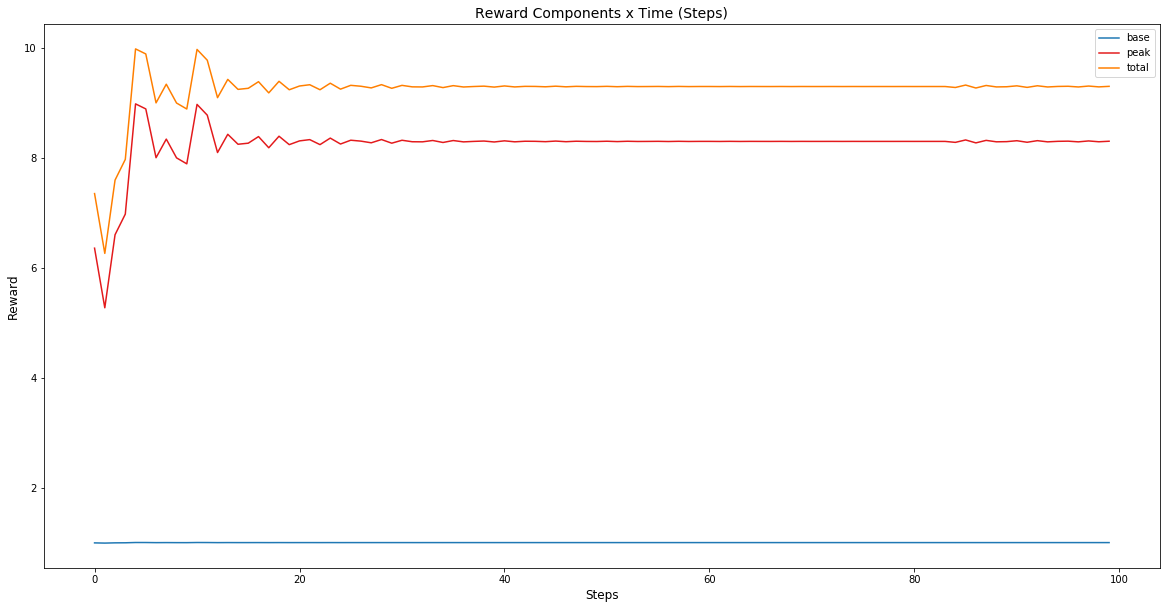

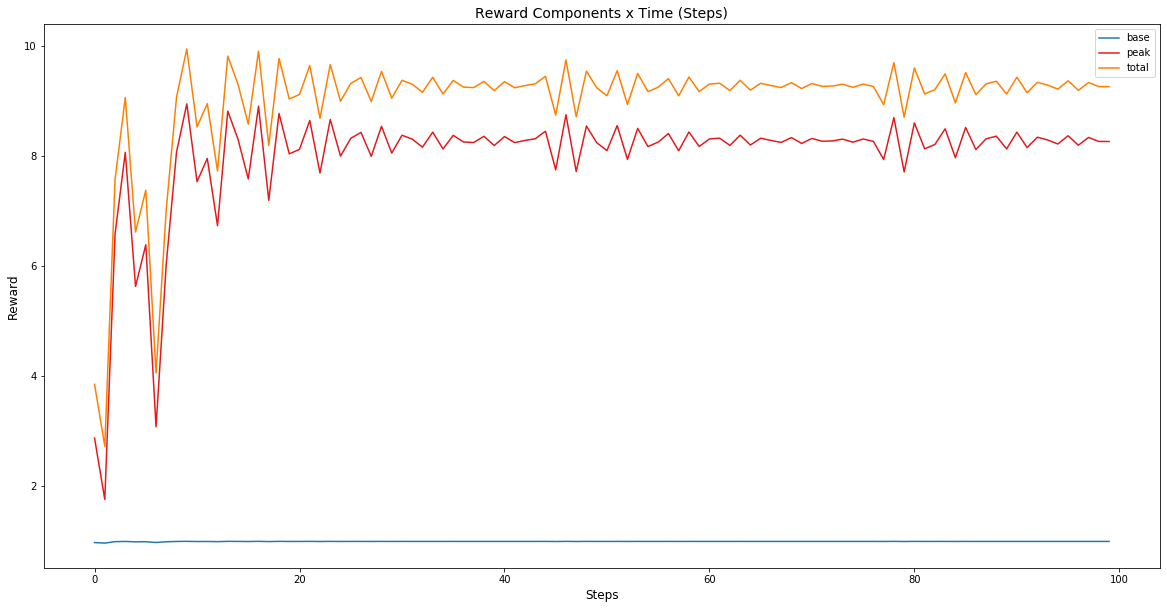

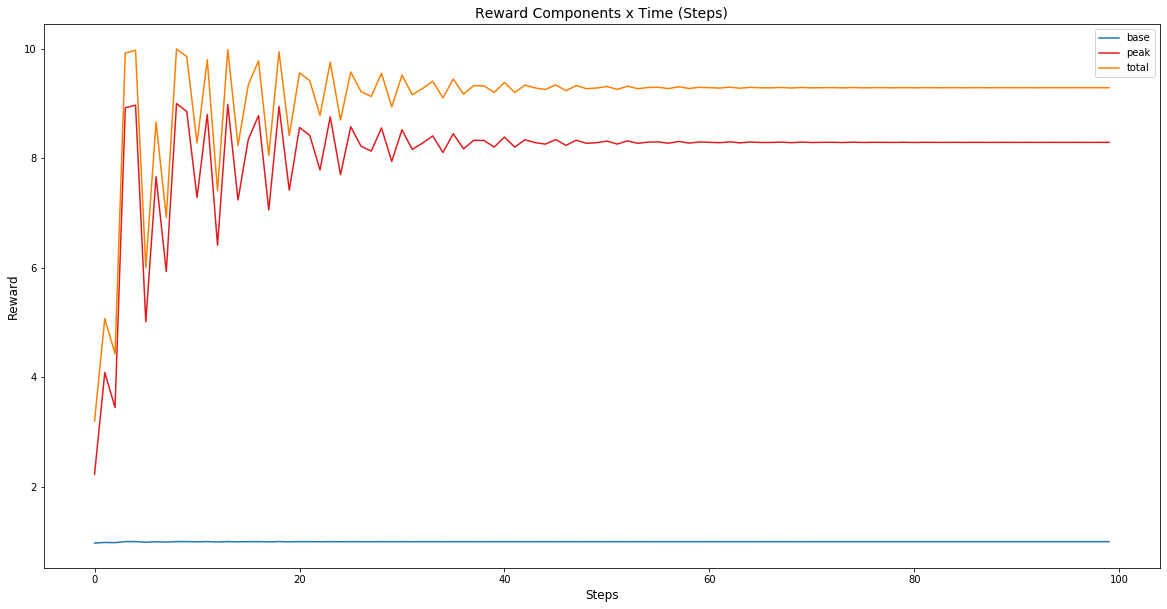

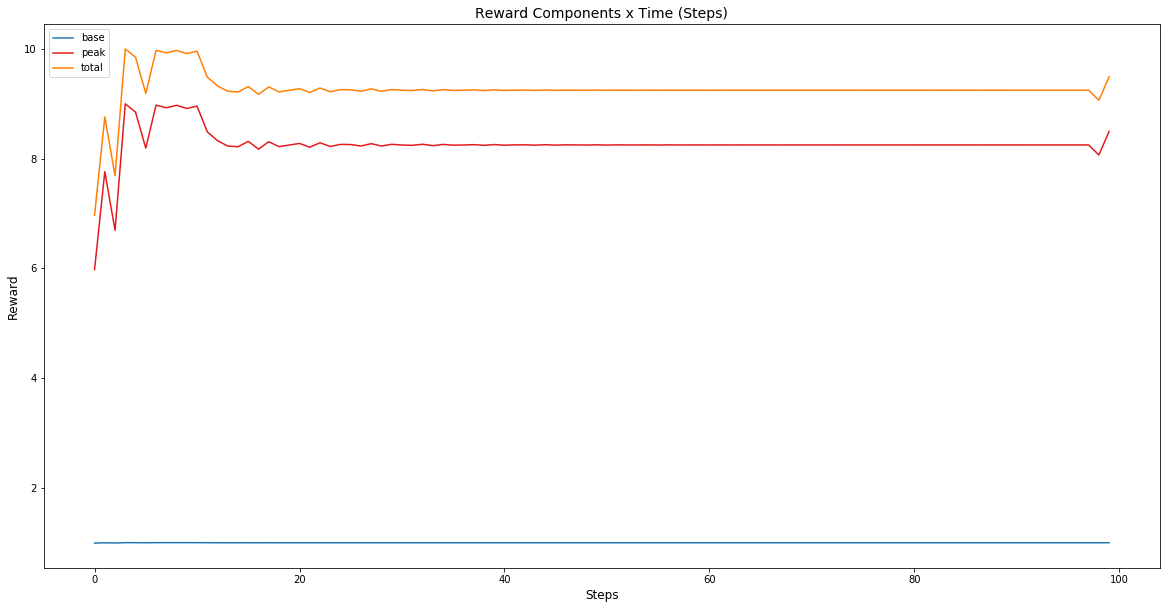

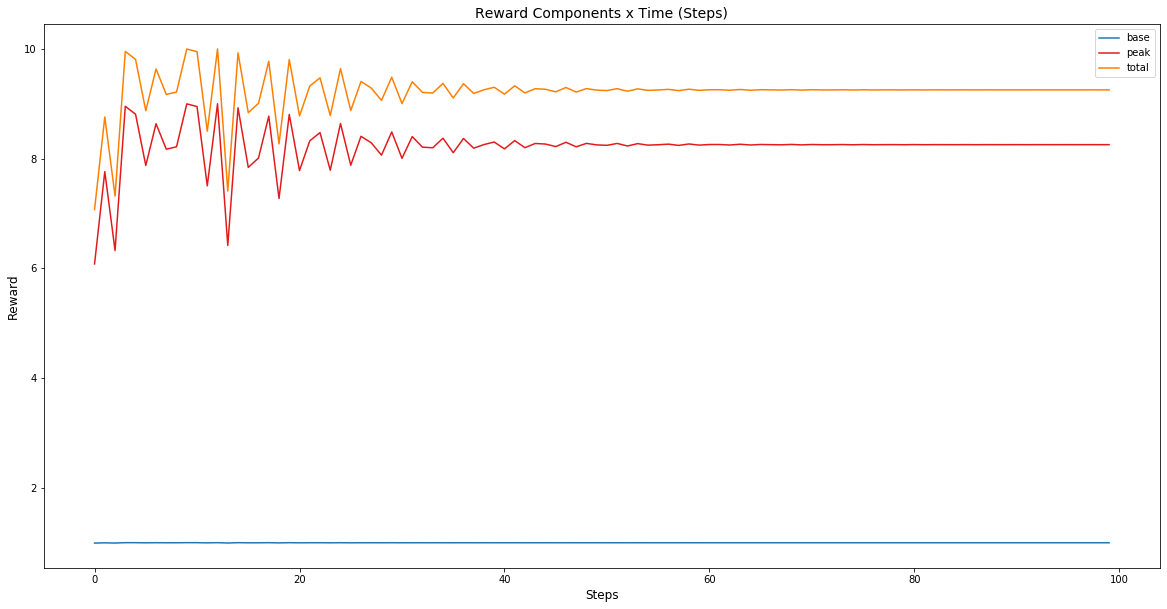

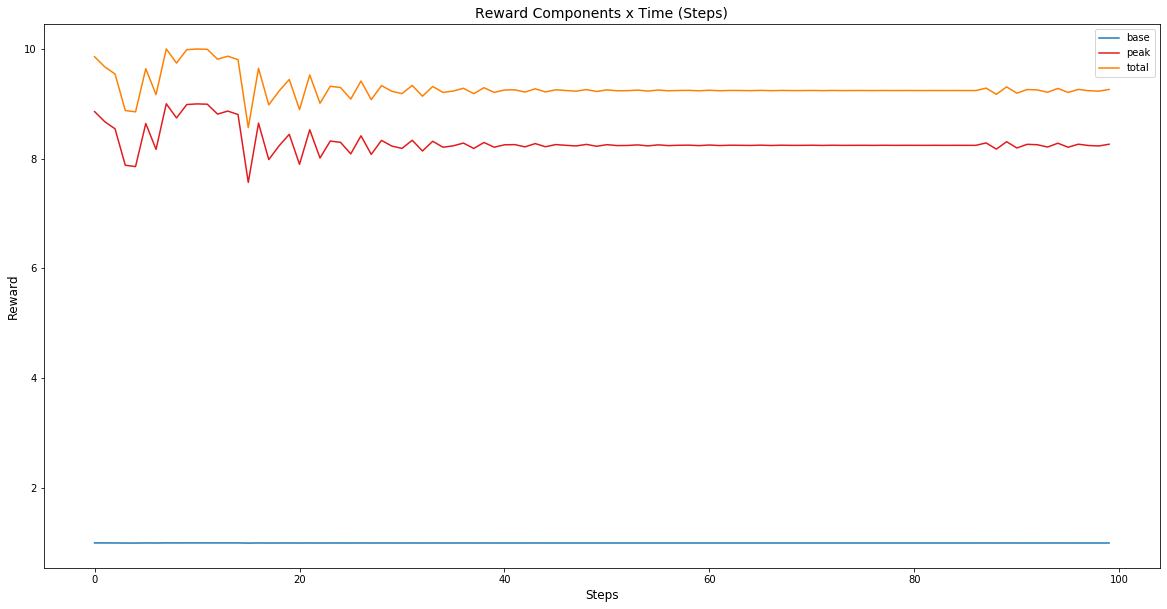

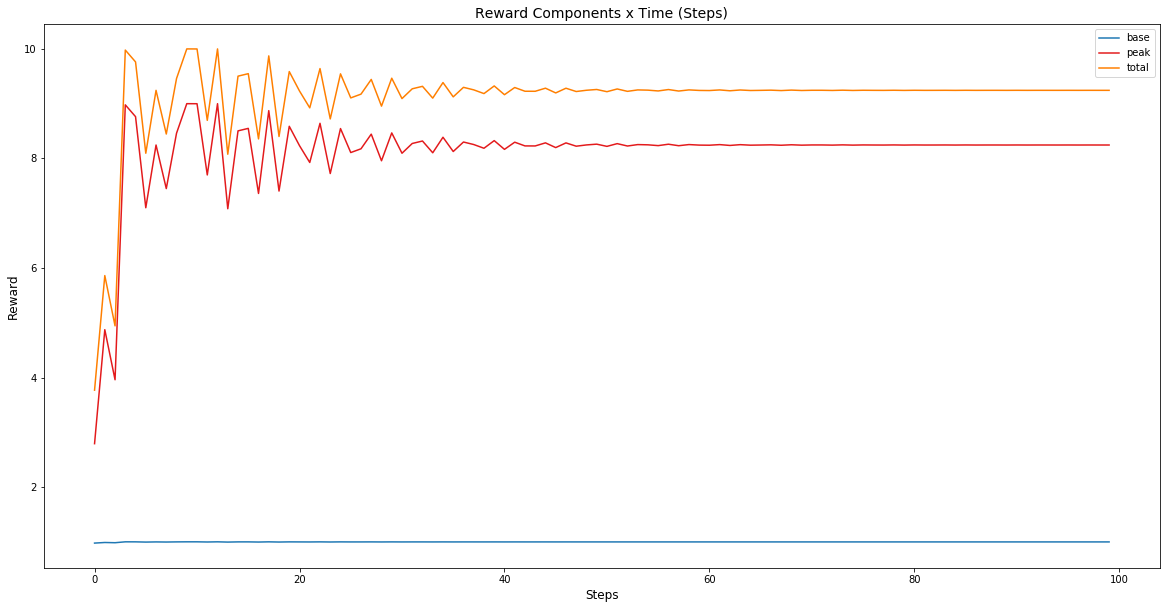

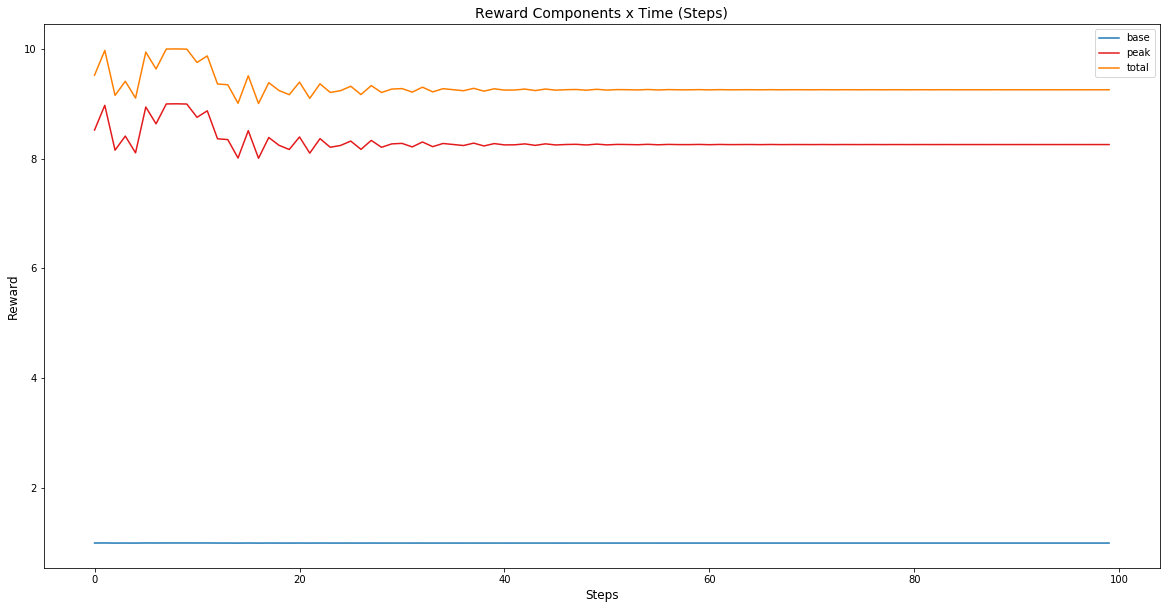

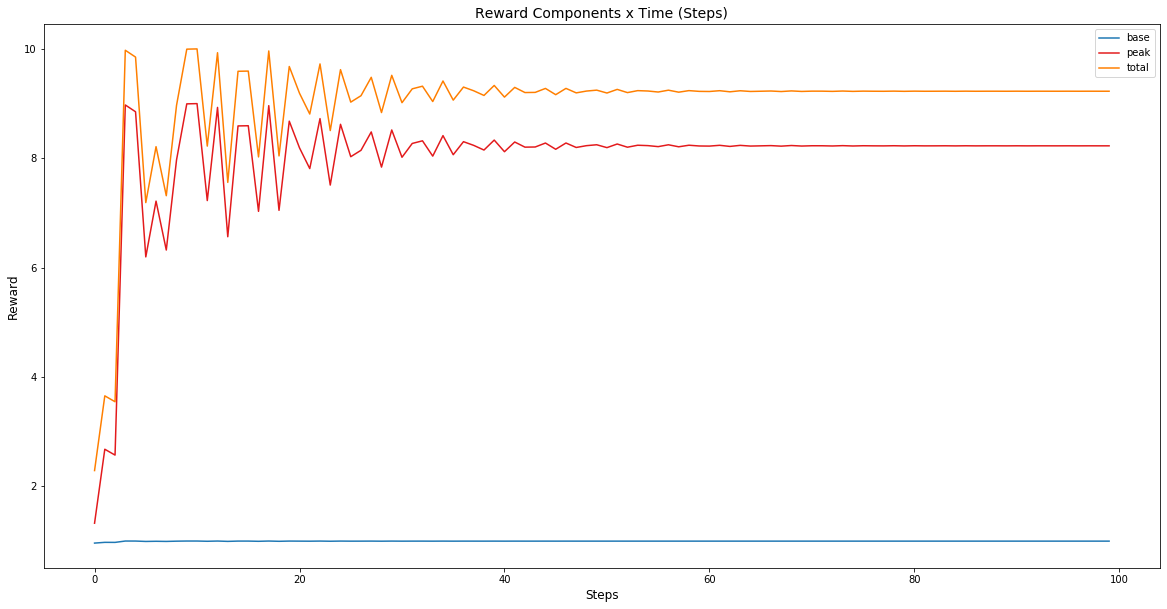

In [11]:
plotExperimentRewardProgression(LearningState().model.allRewards)

Plot the reward progression of the model testing

2768.080716383022

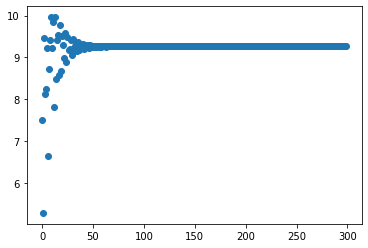

In [12]:
steps = range(STEPS_TO_TEST)
plt.scatter(steps, rewards)
sum(rewards)

Plot all graphs related to the electrical system state during the model testing

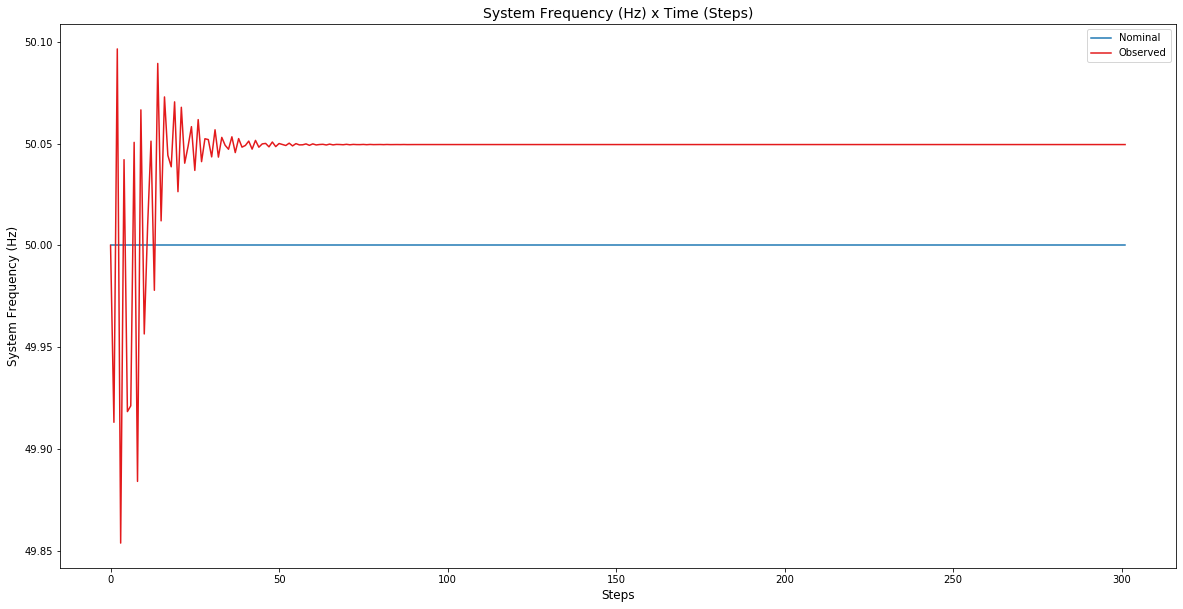

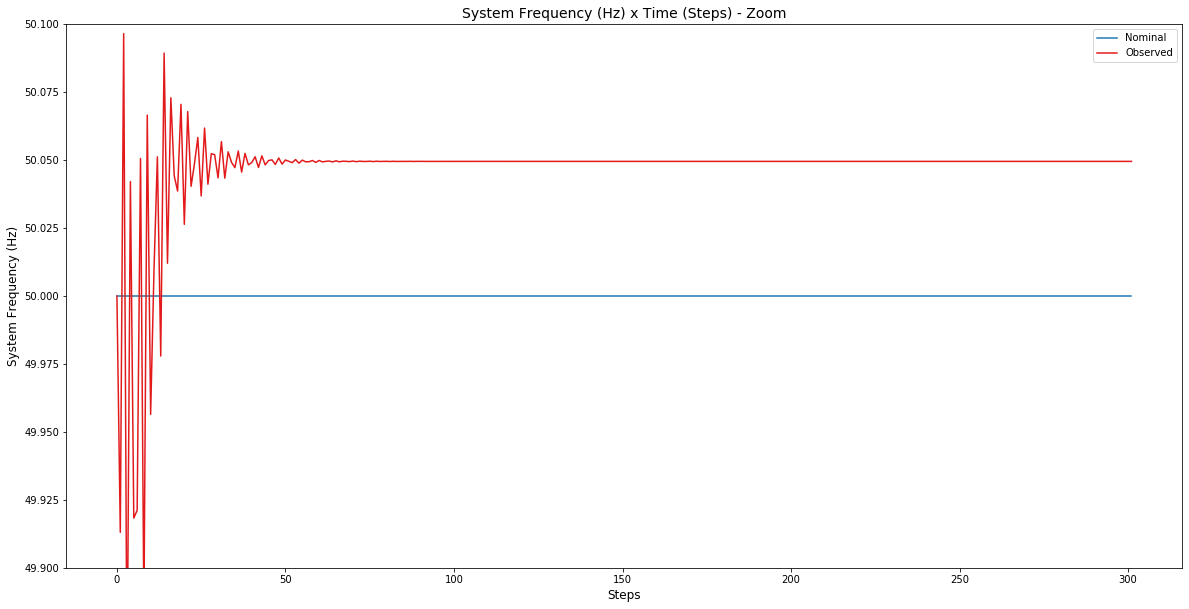

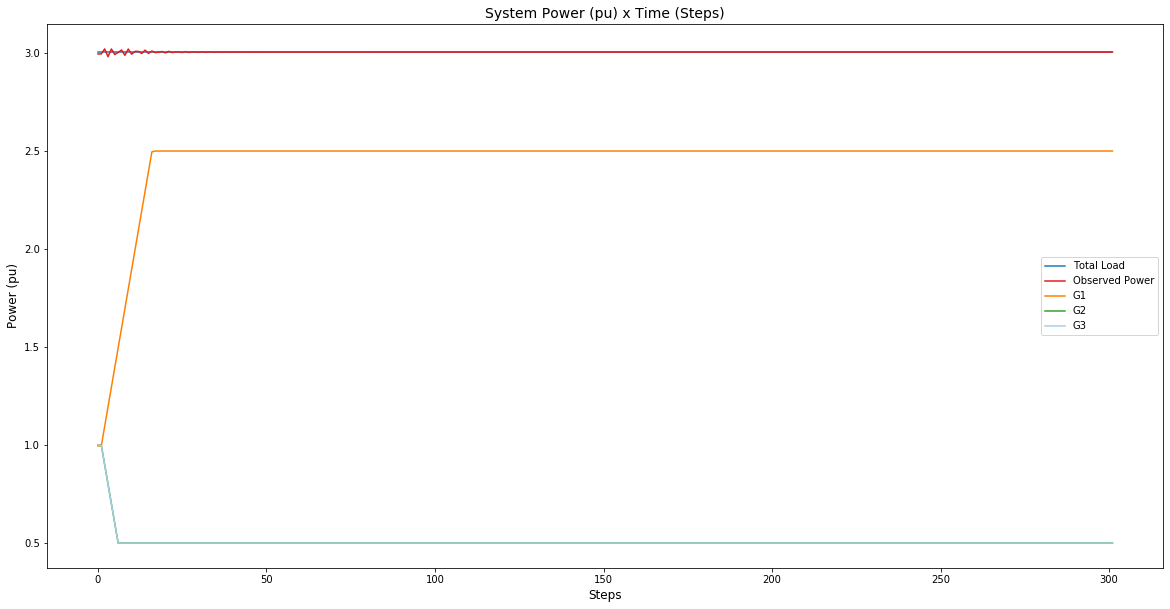

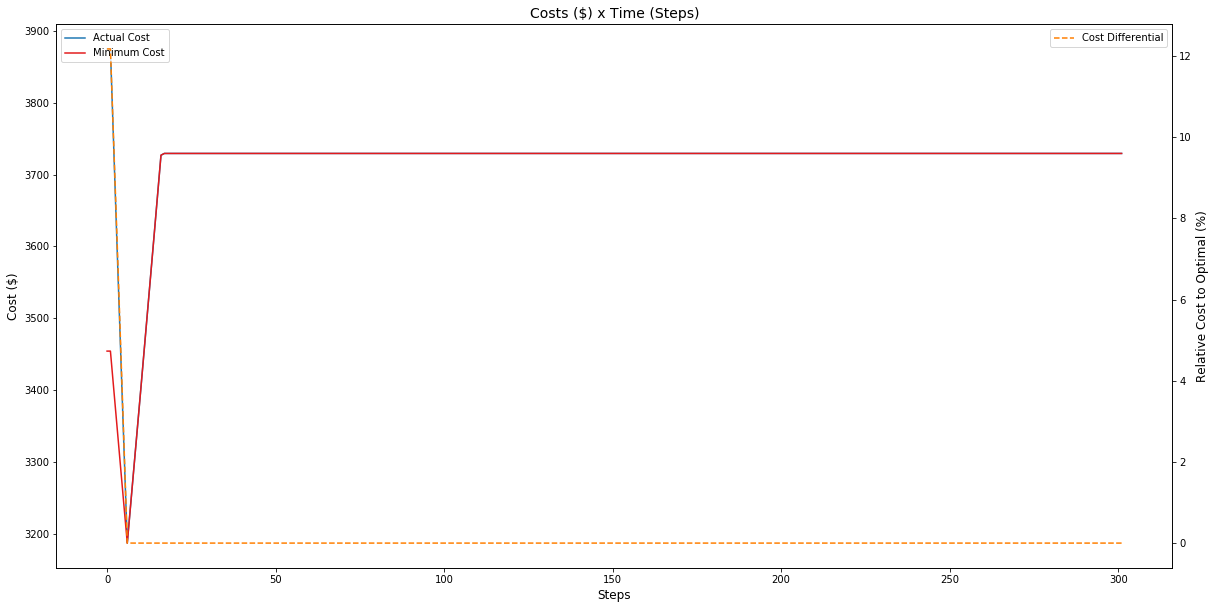

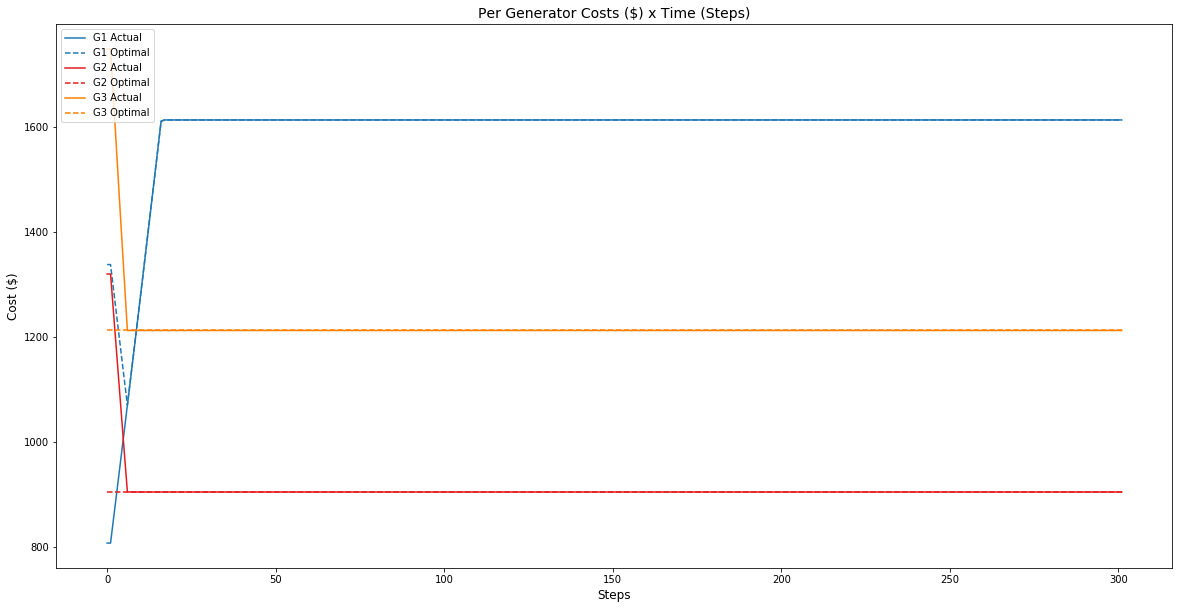

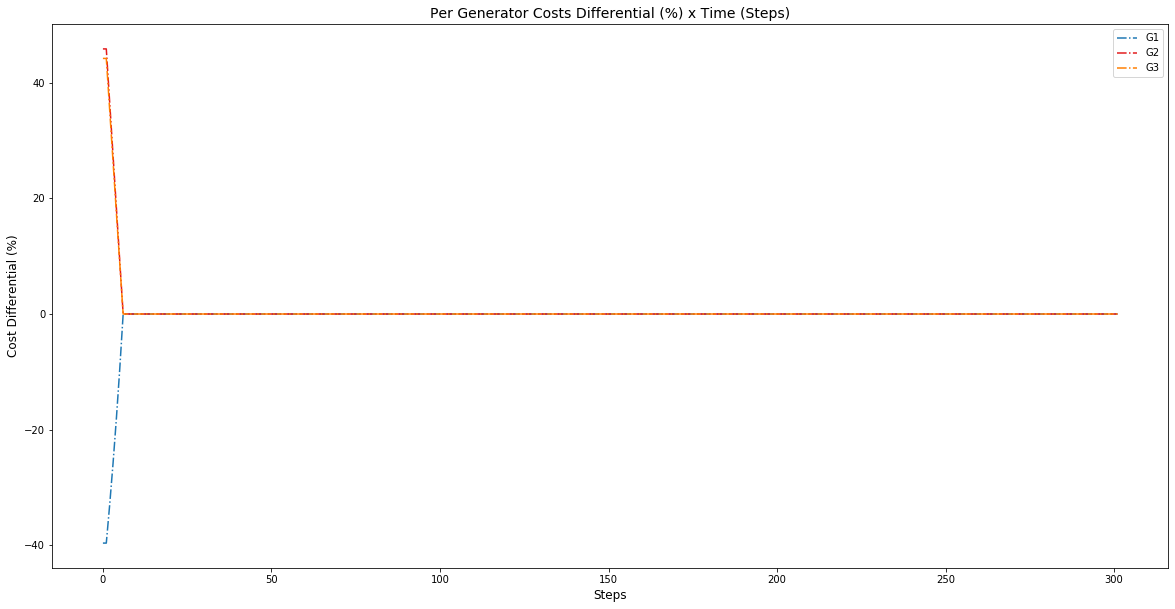

In [13]:
plotAll(electricalSystem.systemHistory)

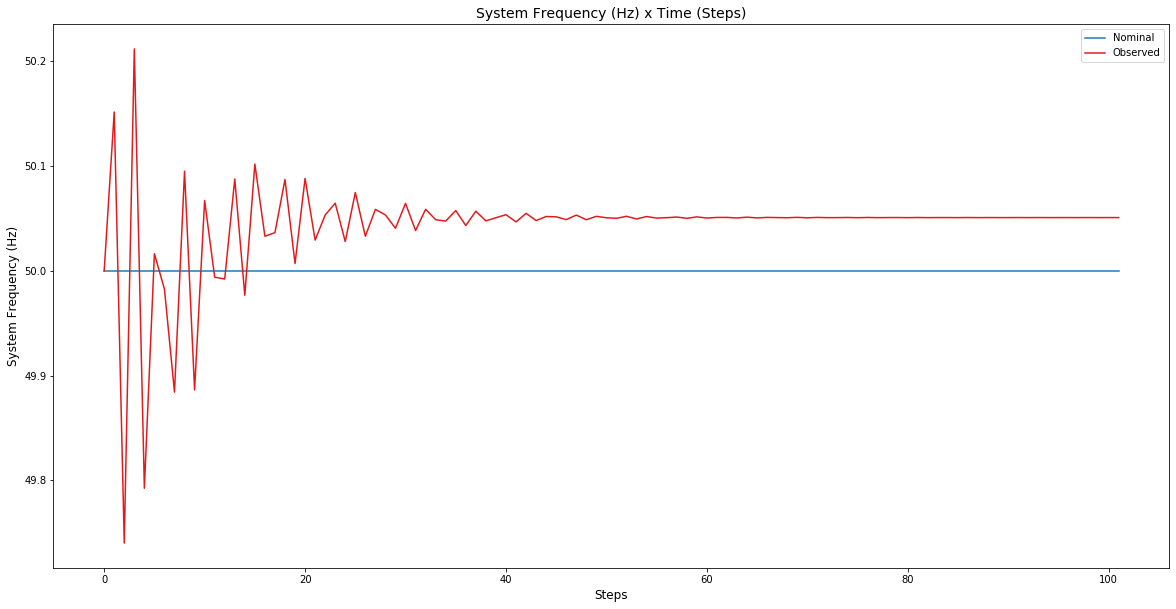

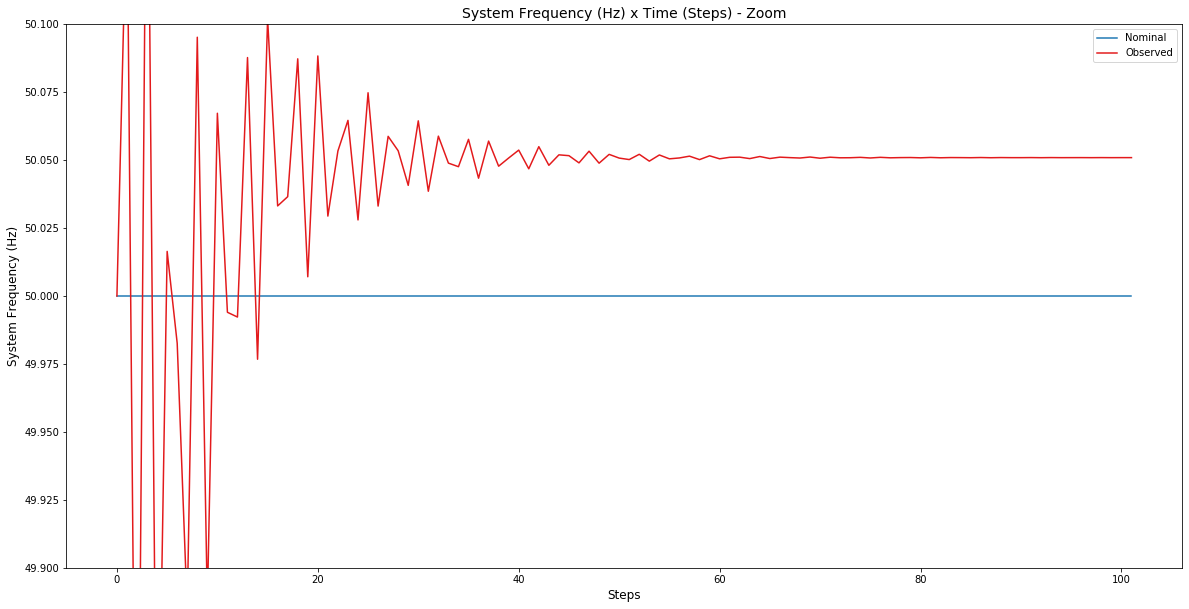

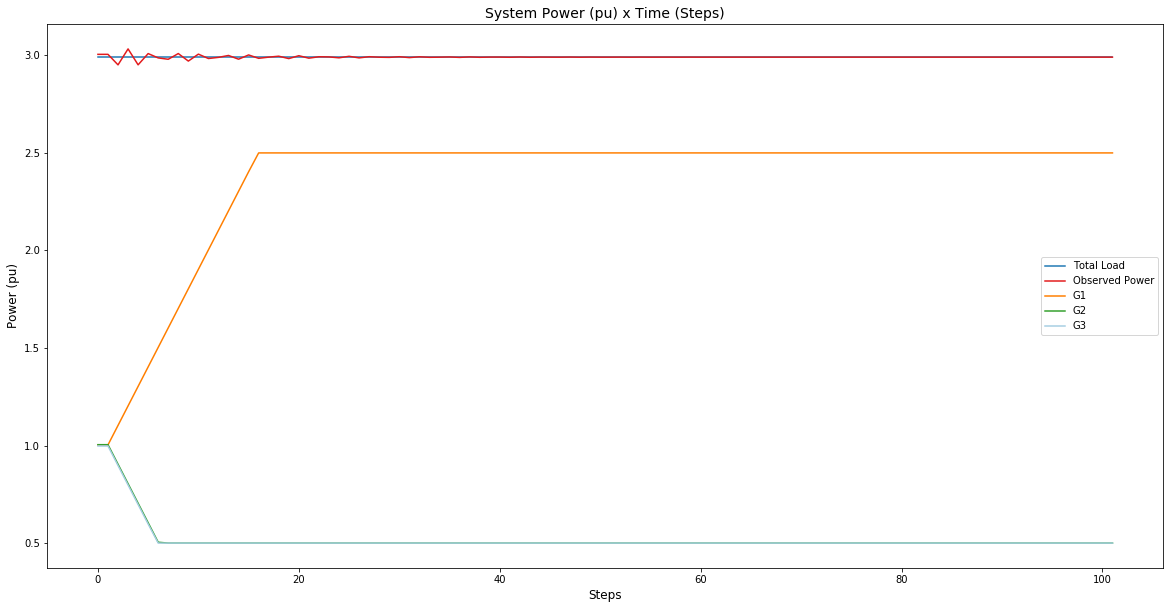

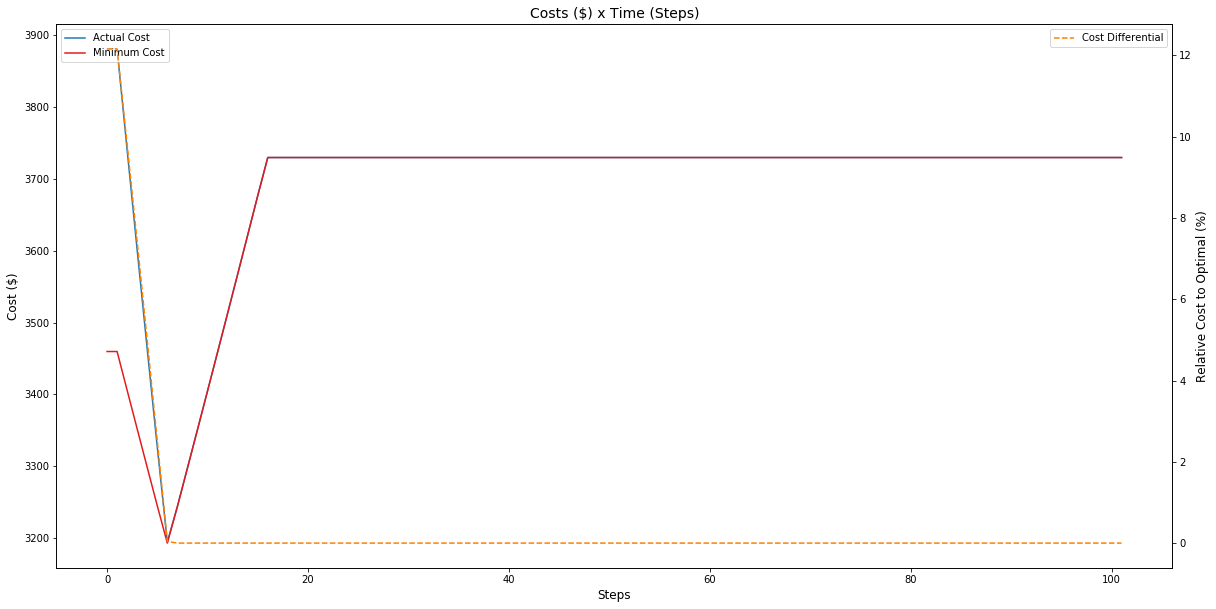

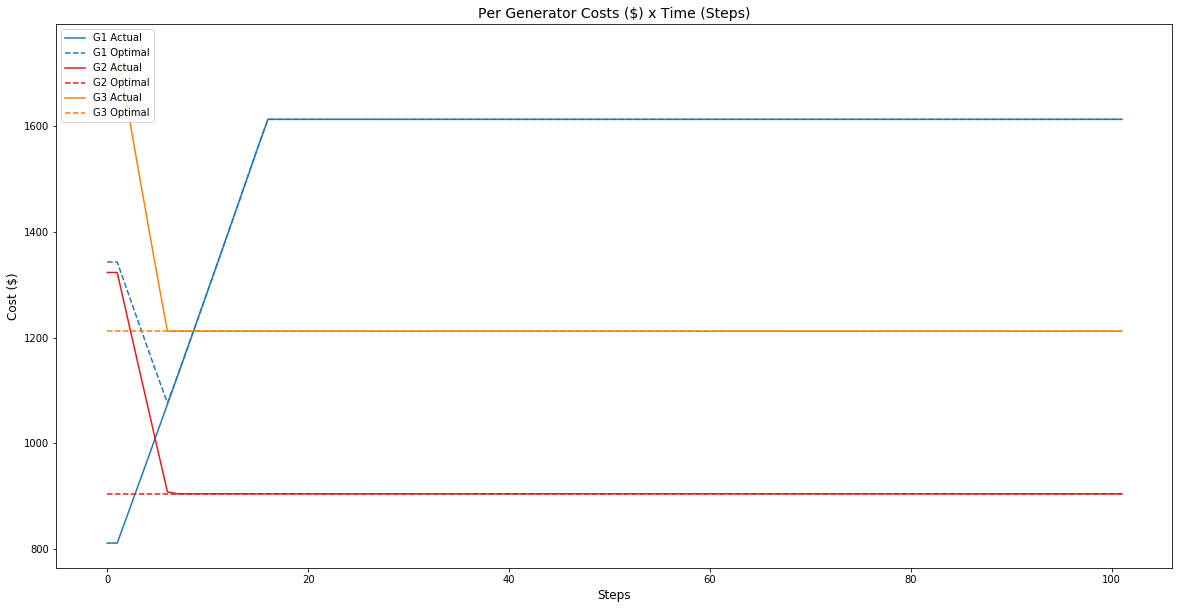

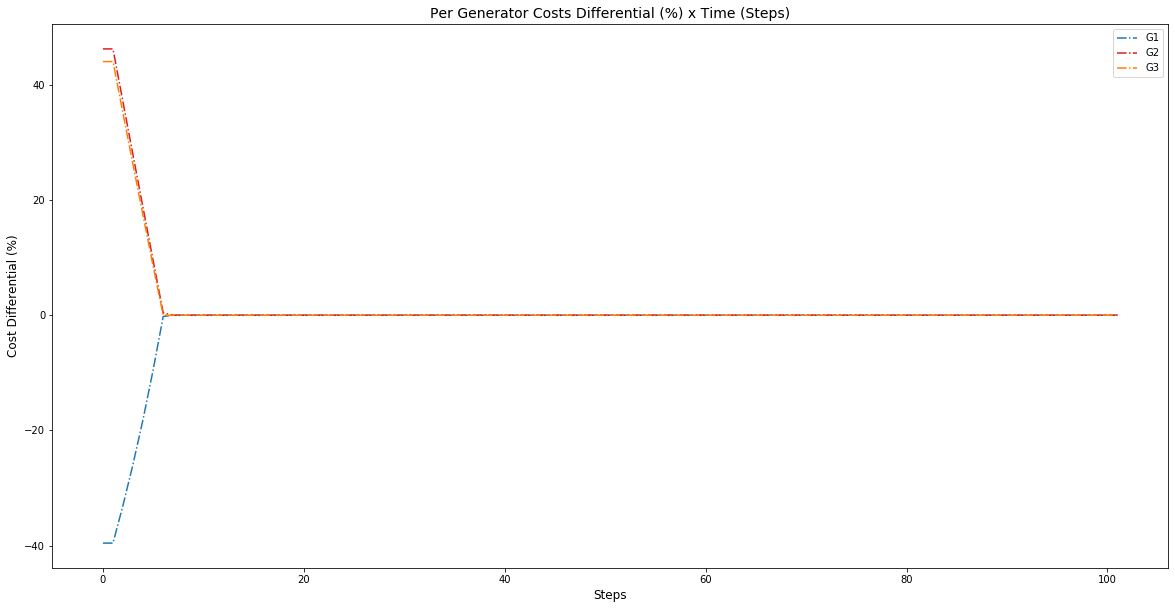

In [14]:
# # Show the last episode ran during training
from learning.learning_state import LearningState
plotAll(LearningState().episode.electricalSystem.systemHistory)

In [15]:
from learning.learning_state import LearningState
import numpy as np

rewList = LearningState().model.cummRewardList

In [16]:
LearningState().model.allRewards

[[{'base': 0.9930606142209012,
   'peak': 6.3537539592467445,
   'total': 7.346814573467646},
  {'base': 0.9893513717736422,
   'peak': 5.2695135201142795,
   'total': 6.258864891887922},
  {'base': 0.9938104091343379,
   'peak': 6.598110284981145,
   'total': 7.591920694115482},
  {'base': 0.9949103576645087,
   'peak': 6.973328401277409,
   'total': 7.968238758941918},
  {'base': 0.9999517603335006,
   'peak': 8.978317786180707,
   'total': 9.978269546514207},
  {'base': 0.9997467754573798,
   'peak': 8.886753052465732,
   'total': 9.886499827923112},
  {'base': 0.9976448642954944,
   'peak': 7.999098976520243,
   'total': 8.996743840815737},
  {'base': 0.9984726770882626,
   'peak': 8.337805518089336,
   'total': 9.336278195177599},
  {'base': 0.9976385341325863,
   'peak': 7.996561614243978,
   'total': 8.994200148376564},
  {'base': 0.9973652339576188,
   'peak': 7.887761807046526,
   'total': 8.885127041004145},
  {'base': 0.999930555119536,
   'peak': 8.968802913832695,
   'tota

TypeError: float() argument must be a string or a number, not 'dict'

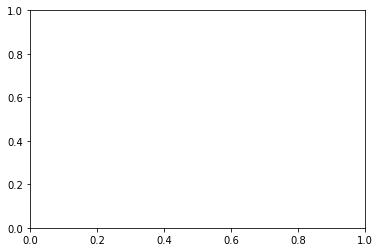

In [17]:
allRewards = LearningState().model.allRewards


for r in allRewards:
    plt.figure()
    plt.scatter(range(len(r)), r)
# sum(rewards)

In [ ]:
plt.scatter(range(len(rewList)), rewList)

In [ ]:
from plots.plot_constants import COLOR_PALETTE, FONT_SIZES

history = electricalSystem.systemHistory
# Get series to be plotted
stepsSeries = history.steps
loads = history.loads
totalLoadSeries = history.totalLoad
generators = history.generators
totalPowerSeries = history.totalPower

plt.figure(0)

# Declare colors to be used
colorTotalLoad = COLOR_PALETTE[0]
colorTotalPower = COLOR_PALETTE[1]
colorsIndividualNodes = COLOR_PALETTE[3:]

# Plot total power/load data
plt.plot(stepsSeries, totalLoadSeries, color=colorTotalLoad)
plt.plot(stepsSeries, totalPowerSeries, color=colorTotalPower)
legendFields = ['Total Load', 'Total Power']

# Multiple scenarios involve a single load, so we make it optional to plot that single load
if(False):
    for idx, loadId in enumerate(loads):
        # Since num loads is variable, colors may wrap around the palette
        loadColor = colorsIndividualNodes[idx % len(colorsIndividualNodes)]
        loadLegend = loadId
        loadSeries = loads[loadId]
        plt.plot(stepsSeries, loadSeries, color=loadColor, linestyle='--')
        legendFields.append(loadLegend)

for idx, generatorId in enumerate(generators):
    # Since num generators is variable, colors may wrap around the palette
    generatorColor = colorsIndividualNodes[idx % len(colorsIndividualNodes)]
    generatorLegend = generatorId
    generatorSeries = generators[generatorId]
    plt.plot(stepsSeries, generatorSeries, color=generatorColor)
    legendFields.append(generatorLegend)
    

summedPow = [x + y for x, y in zip(generators.get('G1'), generators.get('G2'))]
plt.plot(stepsSeries, summedPow, color=COLOR_PALETTE[2])
legendFields.append("Summed Pow")


plt.legend(legendFields)
plt.xlabel('Steps', fontsize=FONT_SIZES['AXIS_LABEL'])
plt.ylabel('Power (pu)', fontsize=FONT_SIZES['AXIS_LABEL'])

plt.title('System Power (pu) x Time (Steps)', fontsize=FONT_SIZES['TITLE'])

plt.show()